# Matrix Porridge
by Kyle Archie, M.Eng

## The Problem

Many COVID-19 survivors report losing their sense of smell and / or taste. While for most this returns over time, others continue to struggle with this issue months later. This problem made me remember an old project I worked on over a decade ago, way back in 2010. I was an entrepreneur at the time with very little time to eat during the day. I thought how, since I was basically just shoveling food into my face to satiate hunger rather than enjoy nicely prepared meals, it would be nice if those meals were at least healthy, even if they weren't all that tasty. 

I immediately thought back to the movie, "The Matrix" and the famous ["tasty wheat scene"](https://www.youtube.com/watch?v=v1EcrD5IyxM). Basically, in this dystopian future where the atmosphere had been ruined and nothing grew above ground, food had to be synthesized. The result was a gelatinous goop... "a single cell protein combined with synthetic aminos, vitamins, and minerals. Everything the body needs." (The Matrix, 1999)

Now there are a million products out there that claim to be healthy meals on the go for you, but looking at the nutrition labels on these, I never really found anything that quite delivered what I wanted. All focused too much on making something "edible." But those days, I was looking for something you'd down like a shot of bad whiskey. Something that got the job done, but didn't necessarily taste good. Not a bar filled with chocolate and peanut butter.

So back to these COVID-19 survivors. Losing their sense of taste is clearly not something anyone would ask for. But perhaps there's some lemonade they can make from these lemons. 

This project aims to find the optimal list of ingredients necessary to create the perfect meal for people who can't taste. It doesn't matter if the ingredients make sense to a chef, just as long as they solve the equation and meet the dietary constraints of a typical adult.

## The Data
For now, I'm going to use my original dataset, which is over a decade old. The reason for this is that the calories in a carrot shouldn't change over time, and the data, which came from the USDA, comes in several dozen separate files, which originally took me hours to stitch together via various joins and SQL queries to create what I wanted. Unfortunately, I no long have the original database I used; only the final export. I intend to revisit this eventually, but for now, it should let us take a first pass at this. 

The latest version of that dataset can be found [here](https://fdc.nal.usda.gov/download-datasets.html). At the time, I put them together using Microsoft Access, which is ideal for these one off sorts of joins, even today. Anyway, I have in the "Matrix Porridge (2010).xlsx" file a couple tabs of interest. First is the core ingredients list, which contains everything from protein content to the vitamins and minerals in 2331 different core ingredients. Second, is the dietary requirements tab. This was based on the needs of a male adult aged 18-30, because that was my demographic at the time. But that can be easily modified to any group, and the variation is mostly around quantity, so it should scale.

The requirements tab is a bit more recent, since updating this was not very difficult. The source is [NIH Dietary Reference Intakes site](https://ods.od.nih.gov/HealthInformation/Dietary_Reference_Intakes.aspx). The reason for using this and not the FDA Daily Recommended Values was that the FDA's numbers are fixed numbers instead of ranges. Obviously some things we aim to maximize and others we hope to minimize, but while we may hope to reduce our sodium intake, for instance, we know that we need at least SOME salt in our diet, or we die. Interestingly enough, the NIH range data shows that the minimum recommended intake for even polyunsaturated fatty acids is not 0. It is 0.6% of our daily intake of calories. Anyway, I wanted to use ranges where applicable here, so I went with the NIH data. 

With that said, there are a lot of vitamins and minerals that can be found in daily supplements, so for the sake of not making things overly complex, I will only be considering core nutritional requirements as constraints here with the exception of sodium (because my early attempts at this had far too much salt in them), and I will be doing so based on an assumed 666.7 calories per meal (i.e. a 2000 calorie daily diet). Based on the NIH data and the assumption that there are [9 calories per gram of fat, and 4 calories for each gram of protein or carbohydrates](https://www.nal.usda.gov/fnic/how-many-calories-are-one-gram-fat-carbohydrate-or-protein), we can calculate the acceptable range in grams for Fat, Protein, Carbohydrates, which we'll need for an apples to apples comparison, since the ingredients data provides all this in grams.

Also, the carbohydrate numbers from the [NIH ranges for macronutrients (fat, carbs, etc.)](https://www.ncbi.nlm.nih.gov/books/NBK56068/table/summarytables.t5/?report=objectonly) don't line up with the values in the [recommended daily allowances for macronutrients](https://www.ncbi.nlm.nih.gov/books/NBK56068/table/summarytables.t4/?report=objectonly) once we convert from calories to grams. After a bit of investigation, the reason appeas to be that these ranges don't break fiber out from the more general carbohydrate category. However, this is where things get a bit complicated. [The calorie content of fiber depends on whether it is dietary or insoluble](https://www.fiberfacts.org/fibers-count-calories-carbohydrates/). Dietary fiber are essentially complex carbohydrates, and so provide the same 4 calories per gram, but insoluble fiber goes through the system without being digested, and so provides no caloric value. A number of sources therefore estimate average fiber value to be about 2 calories per gram, which may be a bit off, but for now, that's what we'll use.

One final issue is that there's a lot of disagreement amongst nutritionists regarding carbohydrates and whether these should be minimized or not. Also, there's been a fair amount of recent research surrounding the microbiome that has found that increasing fiber intake is the easiest way [to increase biodiversity in the gut biome](https://www.medicalnewstoday.com/articles/short-term-increase-in-fiber-alters-gut-microbiome#:~:text=Fiber%20promotes%20a%20healthy%20gut,significantly%20altered%20the%20gut%20microbiome.). Therefore, I will treat the recommended fiber intake as a minimum threshold with each gram accounting for 2 calories and have my fuction use the overall carb max threshold as the overal max for all carbs via a separate conditional statement.

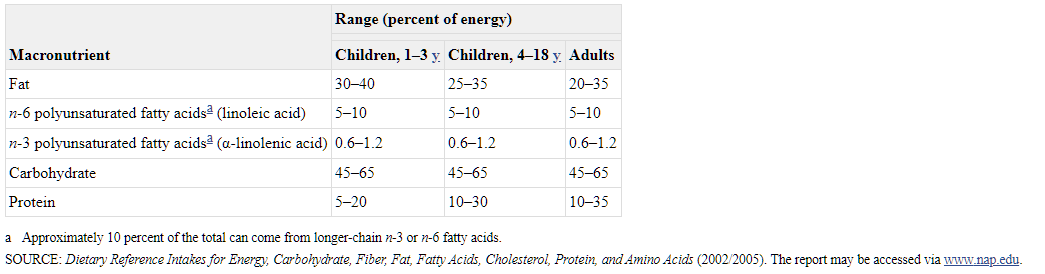

In [2]:
import pandas as pd

ingredients = pd.read_excel("Matrix Porridge (filtered).xlsx", "core ingredients")
ingredients['Sodium']=ingredients['Sodium']/1000 #values are in mg... convert to g
inputs=ingredients[['Energ_Kcal','Protein','Carbohydrt','Fiber_TD','Sugar_Tot','Lipid_Tot','FA_Sat','FA_Poly','Sodium']].T
inputs.columns=ingredients['Shrt_Desc']
# inputs.dropna(inplace=True,axis=1) #some of these ingredients have null values. Remove those. 
inputs.fillna(0,inplace=True)
inputs.head(10)

Shrt_Desc,"BUTTER,WITH SALT","BUTTER,WHIPPED,WITH SALT","BUTTER OIL,ANHYDROUS","CHEESE,BLUE","CHEESE,BRICK","CHEESE,BRIE","CHEESE,CAMEMBERT","CHEESE,CARAWAY","CHEESE,CHEDDAR","CHEESE,CHESHIRE",...,"WHEAT FLR,WHITE (INDUSTRIAL),10% PROT,BLEACHED,UNENR","WHEAT FLR,WHITE (INDUSTRIAL),10% PROT,UNBLEACHED,ENR","WHEAT FLR,WHITE (INDUSTRIAL),11.5% PROT,BLEACHED,ENR","WHEAT FLR,WHITE (INDUSTRIAL),11.5% PROT,BLEACHED,UNENR","WHEAT FLR,WHITE (INDUSTRIAL),11.5% PROT,UNBLEACHED,ENR","WHEAT FLR,WHITE (INDUSTRIAL),13% PROT,BLEACHED,ENR","WHEAT FLR,WHITE (INDUSTRIAL),13% PROT,BLEACHED,UNENR","WHEAT FLR,WHITE (INDUSTRIAL),15% PROT,BLEACHED,ENR","WHEAT FLR,WHITE (INDUSTRIAL),15% PROT,BLEACHED,UNENR",VITAL WHEAT GLUTEN
Energ_Kcal,717.000,717.000,876.000,353.000,371.000,334.000,300.000,376.000,403.000,387.000,...,366.000,366.000,363.000,363.000,363.000,362.000,362.000,362.000,362.000,370.000
Protein,0.850,0.850,0.280,21.400,23.240,20.750,19.800,25.180,24.900,23.370,...,9.710,9.710,11.500,11.500,11.500,13.070,13.070,15.330,15.330,75.160
Carbohydrt,0.060,0.060,0.000,2.340,2.790,0.450,0.460,3.060,1.280,4.780,...,76.220,76.220,73.810,73.810,73.810,72.200,72.200,69.880,69.880,13.790
Fiber_TD,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,2.400,2.400,2.400,2.400,2.400,2.400,2.400,2.400,2.400,0.600
Sugar_Tot,0.060,0.060,0.000,0.500,0.510,0.450,0.460,0.000,0.520,0.000,...,0.490,0.490,1.120,1.120,1.120,1.100,1.100,0.920,0.920,0.000
Lipid_Tot,81.110,81.110,99.480,28.740,29.680,27.680,24.260,29.200,33.140,30.600,...,1.480,1.480,1.450,1.450,1.450,1.380,1.380,1.410,1.410,1.850
FA_Sat,51.368,50.489,61.924,18.669,18.764,17.410,15.259,18.584,21.092,19.475,...,0.302,0.302,0.268,0.268,0.268,0.189,0.189,0.272,0.272,0.272
FA_Poly,3.043,3.012,3.694,0.800,0.784,0.826,0.724,0.830,0.942,0.870,...,0.845,0.845,0.749,0.749,0.749,0.683,0.683,0.712,0.712,0.810
Sodium,0.576,0.827,0.002,1.395,0.560,0.629,0.842,0.690,0.621,0.700,...,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.029


In [3]:
print(ingredients.columns)

Index(['NDB_No', 'Shrt_Desc', 'Water', 'Energ_Kcal', 'Protein', 'Lipid_Tot',
       'Ash', 'Carbohydrt', 'Fiber_TD', 'Sugar_Tot', 'Calcium', 'Iron',
       'Magnesium', 'Phosphorus', 'Potassium', 'Sodium', 'Zinc', 'Copper',
       'Manganese', 'Selenium', 'Vit_C', 'Thiamin', 'Riboflavin', 'Niacin',
       'Panto_Acid', 'Vit_B6', 'Folate_Tot', 'Folic_Acid', 'Food_Folate',
       'Folate_DFE', 'Choline_Tot', 'Vit_B12', 'Vit_A_IU', 'Vit_A_RAE',
       'Retinol', 'Alpha_Carot', 'Beta_Carot', 'Beta_Crypt', 'Lycopene',
       'Lut+Zea', 'Vit_E', 'Vit_D_mcg', 'ViVit_D_IU', 'Vit_K', 'FA_Sat',
       'FA_Mono', 'FA_Poly', 'Cholestrl', 'GmWt_1', 'GmWt_Desc1', 'GmWt_2',
       'GmWt_Desc2', 'Refuse_Pct', 'Expr1053', 'FdGrp_CD'],
      dtype='object')


In [4]:
requirements=pd.read_excel("Matrix Porridge (filtered).xlsx", "requirements (2021)")
requirements['min (g)']/=3
requirements['max (g)']/=3

print(requirements)

                                          Unnamed: 0    min (g)     max (g)
0                                                Fat  14.814815   25.925926
1   n-6 polyunsaturated fatty acidsa (linoleic acid)   3.703704    7.407407
2  n-3 polyunsaturated fatty acidsa (α-linolenic ...   0.444444    0.888889
3                                       Carbohydrate  75.000000  108.333333
4                                            Protein  16.666667   58.333333
5                                             Sodium   0.500000    0.766667


Note: our data does not split the two kinds of polyunsaturated fat, so we'll have to sum these up. There's another dataset I've been looking at which might work better for this, but we'll get to that later.

In [5]:
fat_min=requirements.iloc[0,1]
fat_max=requirements.iloc[0,2]
fat_half_range=(fat_max-fat_min)/2 #calculate this once so we don't need to do it repeatedly in our function later
fat_opt=(fat_min+fat_max)/2

pufat_min=requirements.iloc[1,1]+requirements.iloc[2,2]
pufat_max=requirements.iloc[1,2]+requirements.iloc[2,2]
pufat_half_range=(pufat_max-pufat_min)/2
pufat_opt=(pufat_min+pufat_max)/2

carb_min=requirements.iloc[3,1]
carb_max=requirements.iloc[3,2]
carb_half_range=(carb_max-carb_min)/2
carb_opt=(carb_min+carb_max)/2

protein_min=requirements.iloc[4,1]
protein_max=requirements.iloc[4,2]
protein_half_range=(protein_max-protein_min)/2
protein_opt=(protein_min+protein_max)/2

sodium_min=requirements.iloc[5,1]
sodium_max=requirements.iloc[5,2]
sodium_half_range=(sodium_max-sodium_min)/2
sodium_opt=(sodium_min+sodium_max)/2

## The Approach
This is clearly an optimization problem. However, it is a bit more complicated than what you'd typically use Linear Programming to solve. We could potentially frame it that way... with an A matrix 2330 columns wide. But our objective function here isn't written easily as a function of pure X (our ingredients vector), no matter what we decide to optimize.

There are, however, many modern machine learning approaches that can help us here. The trick is to use a solver / algorithm that works with a custom function instead of a vector. This way, we can to optimize for a custom value function. SciPy's Linear Programming functionality requires that our objective be a vector, but that doesn't really work here. But there are plenty of alternatives, so we'll try a few of those. 

First, however, we need to define what it is we seek to optimize. Eventually, we may wish to make this something the user could select from a list of options (which would also alter constraints), to accommodate different nutrition guides, such as Atkins, or a high fiber diet. Or, maybe we seek to maximize quantity of food while still meeting nutrition guidelines. For now, I'm going to take bit of a fuzzy logic approach, with our function outputting a value that's most optimal when all nutrition requirements are exactly in the center of the ranges and where we impose serious (but linear with a slope) penalties if any nutritional requirements fall outisde the acceptable ranges.

In [6]:
import numpy as np
x=np.zeros(2269)
x[4]=1
x[39]=1
x[554]=1
x[1000]=1
A=inputs.values #get A matrix
y=A.dot(x)
print(y)

[8.3000e+02 5.1940e+01 2.6800e+01 6.0000e+00 5.6400e+00 5.8120e+01
 3.6592e+01 2.0980e+00 7.6300e-01]


In [7]:
def diet_function(ingredients_vector):
    y=A.dot(ingredients_vector)
    calorie_penalty=10*abs(666.7-y[0]) #weighting calories very highly here
    
    protein_penalty=abs(y[1]-protein_opt)
    if abs(y[1]-protein_opt)>protein_half_range:
        protein_penalty*=20
    
    carb_penalty=abs((y[2]+y[3])-carb_opt)
    if carb_penalty>carb_half_range:
        carb_penalty*=20    
    fiber_bonus=y[3]
    sugar_penalty=y[4]

        
    fat_penalty=abs(y[5]-fat_opt)
    if fat_penalty>fat_half_range:
        fat_penalty*=20
       
    sat_fat_penalty=y[6]
    
    pufat_penalty=abs(y[7]-pufat_opt)
    if pufat_penalty>pufat_half_range:
        pufat_penalty*=20
           
    sodium_penalty=abs(y[8]-sodium_opt)
    if sodium_penalty>sodium_half_range:
        sodium_penalty*=100            
            
    value=100-calorie_penalty-protein_penalty-carb_penalty+fiber_bonus-sugar_penalty-fat_penalty-sat_fat_penalty-pufat_penalty-sodium_penalty
    return -value #return negative since this is a minimization problem
        

In [8]:
from scipy.optimize import minimize,dual_annealing

In [9]:
bounds=tuple([(0,10) for i in range(len(ingredients))])
x0=[1]*len(ingredients)

In [10]:
res=minimize(diet_function,x0,method='TNC',bounds=bounds,tol=1e-6,options={'maxiter':int(1e9),'minfev':-100})

In [11]:
%%time
# res=dual_annealing(diet_function,x0=x0,bounds=bounds,maxfun=1e8,local_search_options={'method':'TNC','options':{'maxiter':int(1e9),'minfev':-100}})

Wall time: 0 ns


In [12]:
print(res)

     fun: 2109.4068206642883
     jac: array([5569.21813768, 5581.50914003, 6758.8240654 , ..., 5037.38206135,
       5037.38206135, 4010.88204853])
 message: 'Converged (|x_n-x_(n-1)| ~= 0)'
    nfev: 14307810
     nit: 2117
  status: 2
 success: True
       x: array([0., 0., 0., ..., 0., 0., 0.])


In [13]:
solution=res.x

In [14]:
output=pd.Series(A.dot(solution),index=inputs.index)
print(output)

Energ_Kcal    666.700000
Protein        48.623464
Carbohydrt    132.148711
Fiber_TD       43.081574
Sugar_Tot      47.571787
Lipid_Tot       7.716130
FA_Sat          1.469776
FA_Poly         2.997426
Sodium          4.613850
dtype: float64


Note: this solution looks pretty good, but it's a bit high in both carbs and sodium. Sugar content is high too, thought it's offset by a very nice fiber content. On the sugar side, they do appear to be natural sugars from vegetables, at least. We may want to revise our value function a bit, but this is not a bad initial result.

In [15]:
solution_ds=pd.Series(solution,index=ingredients.Shrt_Desc)
solution_ds.to_csv('matrix_porridge_init_recipe.csv')
solution_ds=solution_ds[solution_ds>0.4]
print(solution_ds)

Shrt_Desc
ACEROLA JUICE,RAW                                            0.418687
BUTTERBUR,CANNED                                             0.859419
CABBAGE,CHINESE (PAK-CHOI),RAW                               0.594643
CABBAGE,CHINESE (PAK-CHOI),CKD,BLD,DRND,WO/SALT              0.507121
CUCUMBER,WITH PEEL,RAW                                       0.439779
CUCUMBER,PEELED,RAW                                          0.556533
GOURD,WHITE-FLOWERED (CALABASH),CKD,BLD,DRND,WO/SALT         0.541778
LETTUCE,BUTTERHEAD (INCL BOSTON&BIBB TYPES),RAW              0.640030
PUMPKIN FLOWERS,CKD,BLD,DRND,WO/SALT                         0.447101
PUMPKIN,CKD,BLD,DRND,WO/SALT                                 0.551579
SQUASH,SMMR,CROOKNECK&STRAIGHTNECK,RAW                       0.430714
SQUASH,SMMR,CROOKNECK&STRAIGHTNECK,CND,DRND,SOLID,WO/SALT    0.408181
SQUASH,SUMMER,SCALLOP,RAW                                    0.434071
SQUASH,SMMR,SCALLOP,CKD,BLD,DRND,WO/SALT                     0.449769
SQUASH,SMM

An interesting note here is that we have clusters of similar ingredients. We could probably greatly reduce the work of the algorithm by first using an unsupervised clustering algorithm on the input data to trim our ingredients list down. We could then add some complexity on the value side by adding in more dietary considerations. We'll try that next.